In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

## suppress warinings
import warnings
warnings.filterwarnings('ignore')

## Non-linear classification with 2 layer neural network

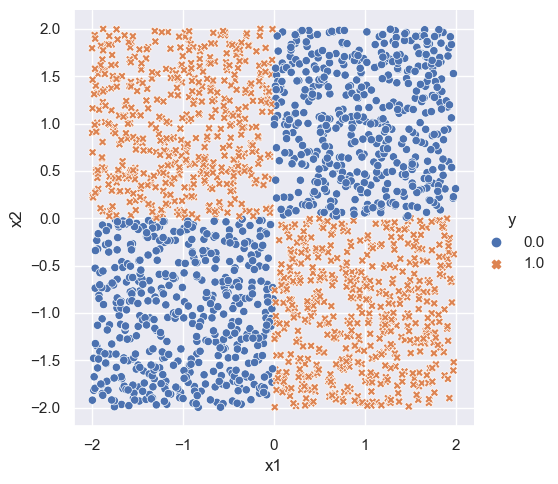

In [2]:

## Generating the data

n = 2000
p = 2
x = np.random.uniform(-2, 2, size=(n, p))
y = ((x[:,0] < 0) & (x[:, 1] > 0)).astype(int) + ((x[:,0] > 0) & (x[:, 1] < 0)).astype(int)

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view(-1, 1)

ntrain = 500
x_train = x[:ntrain]
y_train = y[:ntrain]
x_test = x[ntrain:]
y_test = y[ntrain:]

df = np.hstack([y.reshape((n, 1)), x])
df = pd.DataFrame(df, columns = ['y', 'x1', 'x2'])

sns.set_theme()
xor_plot = sns.relplot(df, x='x1', y='x2', hue='y', style='y')

In [3]:

## defining a two-layer neural network

class NNet(nn.Module):

    def __init__(self, input_dim, hidden_dim, out_dim):
        super(NNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.layer1(x)
        ##x = nn.Sigmoid()(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)

        return(x)

def loss_fn(y_pred, y_true):
    loss_vec = y_true * torch.log(y_pred + 1e-8) + (1 - y_true) * torch.log(1 - y_pred + 1e-8)
    output = -1.0 * torch.mean(loss_vec)
    return(output)


In [4]:


hidden_dim = 20

model = NNet(x.shape[1], hidden_dim, 1)

optimizer = optim.SGD(model.parameters(), lr=0.1)

pred = model(x_train)

epochs = 200

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=50, shuffle=True)

for i in range(epochs):
    for x_batch, y_batch in train_loader:
        loss = loss_fn(model(x_batch), y_batch.view(-1, 1))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if i % 10 == 0:
        print("epoch: " + str(i) + ", loss: " + str(loss.item()))


epoch: 0, loss: 0.6958242654800415
epoch: 10, loss: 0.6898103952407837
epoch: 20, loss: 0.6797153949737549
epoch: 30, loss: 0.6723144054412842
epoch: 40, loss: 0.667732834815979
epoch: 50, loss: 0.7003528475761414
epoch: 60, loss: 0.6865022778511047
epoch: 70, loss: 0.685528039932251
epoch: 80, loss: 0.670896053314209
epoch: 90, loss: 0.6762698888778687
epoch: 100, loss: 0.6512312889099121
epoch: 110, loss: 0.6433553099632263
epoch: 120, loss: 0.6355425119400024
epoch: 130, loss: 0.5607717633247375
epoch: 140, loss: 0.541678786277771
epoch: 150, loss: 0.530524492263794
epoch: 160, loss: 0.48310157656669617
epoch: 170, loss: 0.43021446466445923
epoch: 180, loss: 0.4182519018650055
epoch: 190, loss: 0.37696266174316406


Test error: tensor(0.0667)


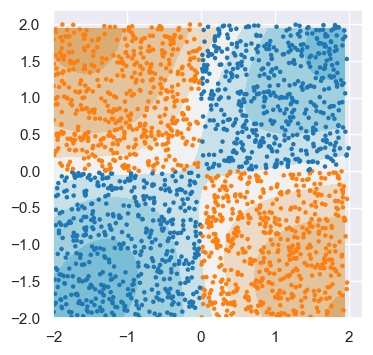

In [5]:

#print("layer1 weights: " + str(model.layer1.weight.data))
#print("layer2 weights: " + str(model.layer2.weight.data))

y_pred = model(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = torch.tensor(y_pred, dtype=torch.float).view(-1,1)

test_err = abs(y_pred - y_test).mean()
print("Test error: " + str(test_err))


## visualization

x1 = np.arange(-2, 2, 0.05)
x2 = np.arange(-2, 2, 0.05)

x_grid_np = np.array([(i, j) for i in x1 for j in x2])
y_grid_np = ((x_grid_np[:,0] < 0) & (x_grid_np[:, 1] > 0)).astype(int) + \
    ((x_grid_np[:,0] > 0) & (x_grid_np[:, 1] < 0)).astype(int)

x_grid = torch.tensor(x_grid_np, dtype=torch.float)
y_grid = torch.tensor(y_grid_np)

y_pred = model(x_grid)

y_pred_np = y_pred.detach().numpy()
y_pred_np = y_pred_np.reshape(x1.shape[0], x2.shape[0])

seaborn_cols = sns.color_palette("tab10")
cols = [seaborn_cols[int(i)] for i in y]

custom_cmap = sns.diverging_palette(220, 50, s=70, l=70, as_cmap=True)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.contourf(x1, x2, y_pred_np, cmap=custom_cmap)
ax.scatter(x[:,0], x[:, 1], c=cols, s=5)
